In [3]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from data_quality import *

In [4]:
clean_flights, dirty_flights = partition_data_files('tmp/FLIGHTS/*.csv')
clean_fb, dirty_fb = partition_data_files('tmp/FBPosts2/*.csv')

In [5]:
flights_clean_completeness_ratio_df, flights_dirty_completeness_ratio_df = completeness_dataframes(clean_flights, dirty_flights)

In [6]:
fb_clean_completeness_ratio_df, fb_dirty_completeness_ratio_df = completeness_dataframes(clean_fb, dirty_fb)

In [7]:
flights_clean_distinct_counts_df, flights_dirty_distinct_counts_df = distinct_counts_dataframes(clean_flights, dirty_flights)

In [8]:
fb_clean_distinct_counts_df, fb_dirty_distinct_counts_df = distinct_counts_dataframes(clean_fb, dirty_fb)

In [11]:
def determine_acceptable_metric_range(batches):
    
    completeness_df, __ = completeness_dataframes(batches, batches)
    distinct_df, __ = distinct_counts_dataframes(batches, batches)
    completeness_means = completeness_df.mean(axis=1)
    completeness_vars = np.sqrt(completeness_df.var(axis = 1, ddof=len(batches)-1))
    completeness_ste = completeness_df.std(axis=1)
    
    completeness_range = pd.DataFrame(columns = ['min', 'max'])
    completeness_range['min'] = completeness_means - 2*completeness_vars
    completeness_range['max'] = completeness_means + 2*completeness_vars
#     completeness_range['min'] = completeness_means - 3*completeness_ste
#     completeness_range['max'] = completeness_means + 3*completeness_ste
    
    distinct_means = distinct_df.mean(axis=1)
    distinct_vars = np.sqrt(distinct_df.var(axis = 1, ddof=len(batches)-1))
    distinct_ste = distinct_df.std(axis=1)
    
    distinct_range = pd.DataFrame(columns = ['min', 'max'])
    distinct_range['min'] = distinct_means - 2*distinct_vars
    distinct_range['max'] = distinct_means + 2*distinct_vars
#     distinct_range['min'] = distinct_means - 3*distinct_ste
#     distinct_range['max'] = distinct_means + 3*distinct_ste
    return completeness_range, distinct_range

In [10]:
def is_acceptable(train_batch, test_batch):
    completeness_range, distinct_range = determine_acceptable_metric_range(train_batch)
    test_batch_completeness, __ = completeness_dataframes(test_batch, test_batch)
    test_batch_distinct, __ = distinct_counts_dataframes(test_batch, test_batch)
    completeness_within_range = 0
    distinct_within_range = 0
    for i in range(len(test_batch_distinct.values)):
        if test_batch_distinct.values[i][0] >= (distinct_range[i:i+1]['min'][0]) and test_batch_distinct.values[i][0] <= (distinct_range[i:i+1]['max'][0]):
            distinct_within_range = distinct_within_range + 1
        if test_batch_completeness.values[i][0] >= (completeness_range[i:i+1]['min'][0]) and test_batch_completeness.values[i][0] <= (completeness_range[i:i+1]['max'][0]):
            completeness_within_range = completeness_within_range + 1
    
    
    if completeness_within_range/test_batch_completeness.shape[0] > .8 and distinct_within_range/test_batch_completeness.shape[0] > .8:
        return True
    else:
        return False

In [ ]:
batch_size = 7
for i in range(len(clean_flights)-batch_size):
    print(is_acceptable(clean_flights[i:i+batch_size], clean_flights[i+batch_size: i+batch_size+1]))

In [64]:
def analysis(i, train_type, clean, dirty, batch_size):
    if train_type == 'rolling':
        dirty_val = is_acceptable(clean[i:i+batch_size], dirty[i+batch_size: i+batch_size+1])
        clean_val = is_acceptable(clean[i:i+batch_size], clean[i+batch_size: i+batch_size+1])
    else:
        dirty_val = is_acceptable(clean[0:i+batch_size], dirty[i+batch_size: i+batch_size+1])
        clean_val = is_acceptable(clean[0:i+batch_size], clean[i+batch_size: i+batch_size+1])
    if dirty_val == False:
        dirty_correct = True
    else:
        dirty_correct = False
    if clean_val== True:
        clean_correct = True
    else:
        clean_correct = False
    row = [train_type, batch_size, i, clean_correct, dirty_correct]
    return row  

def plot_batch(dataset, batch_size_range):
    df_valid = dataset[dataset.test_batch.isnull() == False]
    
    for train_type in ['rolling', 'increasing']:
        df = df_valid[df_valid.train_type == train_type]
        for batch_size in batch_size_range:
            data = df[df.batch_size == batch_size]
            plt.figure(figsize=(15, 5))
            plt.plot(data.test_batch+batch_size, data.clean_correct, 'b-o', label = 'clean')
            plt.plot(data.test_batch+batch_size, data.dirty_correct,'r-o', label = 'dirty')
            plt.xlabel('test batch')
            plt.ylabel('0 = wrong, 1 = correct')
            plt.title('Trained on %s Range of Batch Size = %d' %(train_type.title(), batch_size))
            plt.legend()
            plt.show()

In [60]:
fb_analysis = pd.DataFrame(columns=['train_type', 'batch_size', 'test_batch', 'clean_correct', 'dirty_correct'])
counter = 0

In [62]:
fb_analysis = pd.read_csv('fb_batch_analysis.csv')

In [ ]:
for train_type in ['rolling', 'increasing']:
    for batch_size in range(1, 10):
        for i in range(len(clean_fb)-batch_size):
            row = analysis(i, train_type, clean_fb, dirty_fb, batch_size)
            fb_analysis.loc[counter] = row
            counter = counter + 1

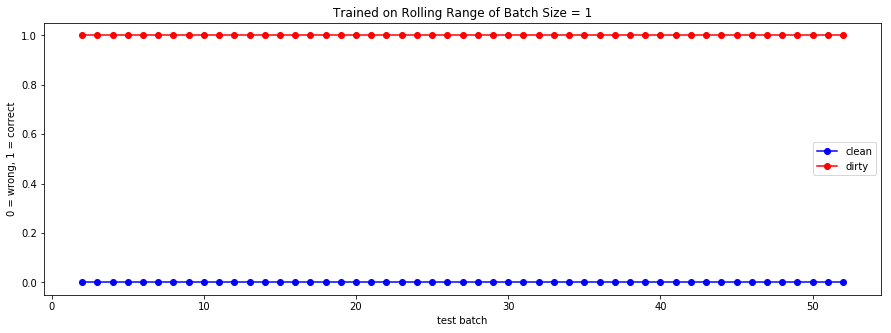

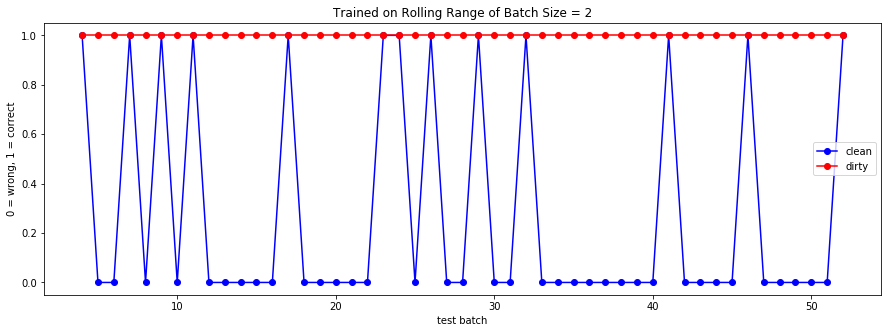

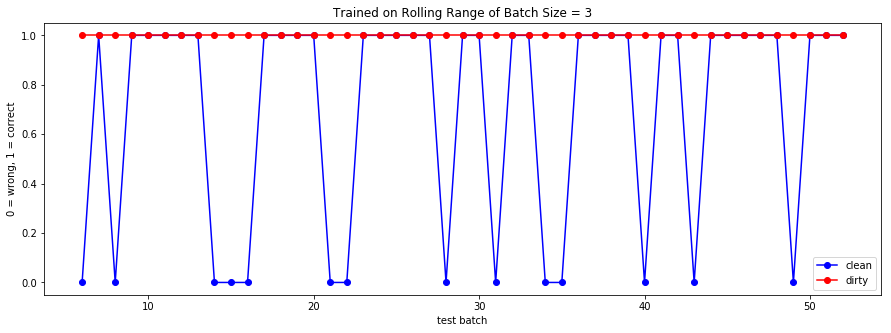

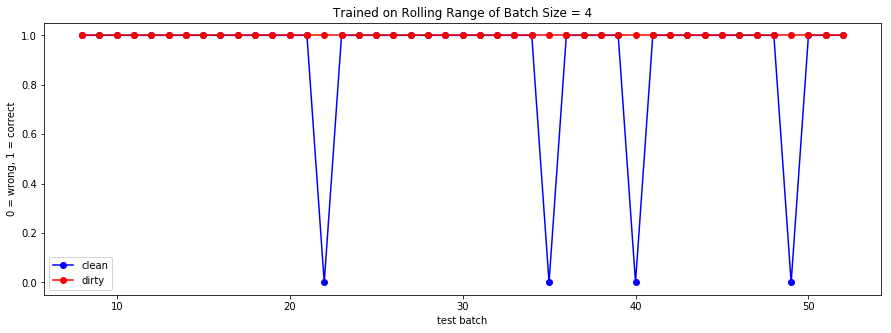

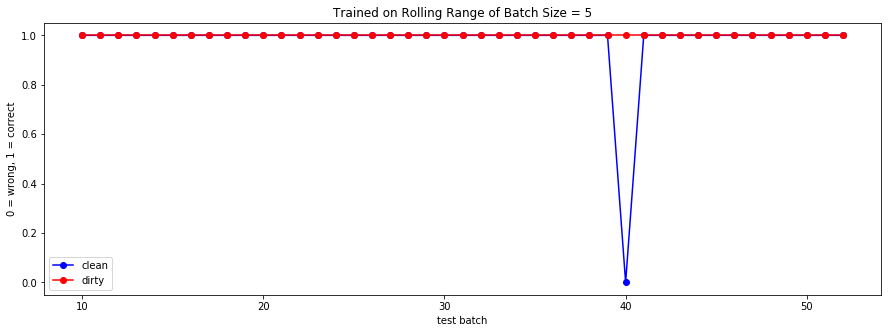

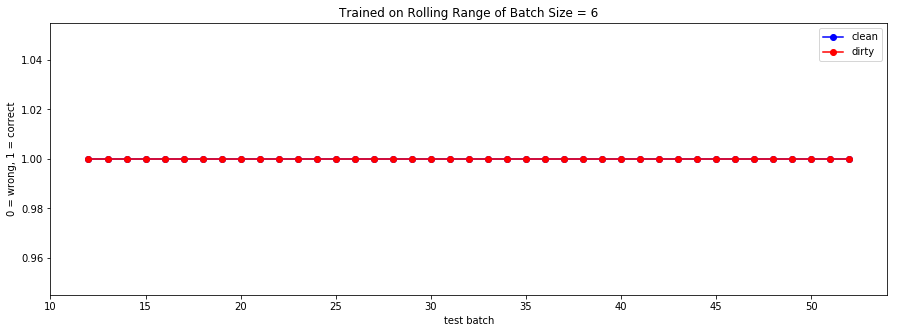

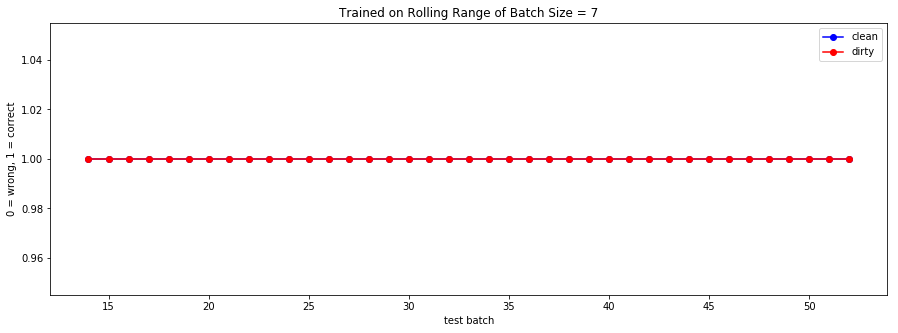

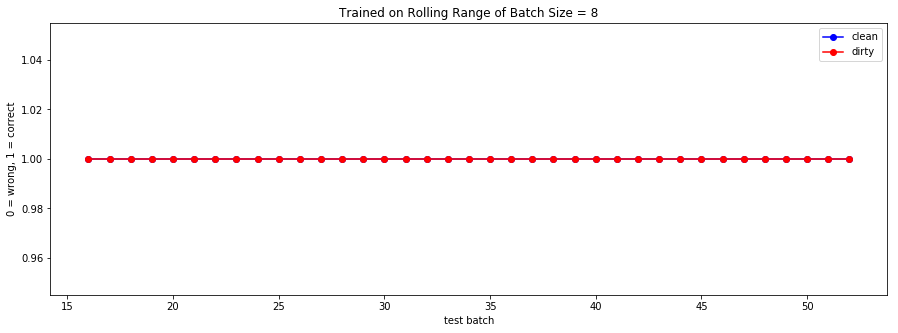

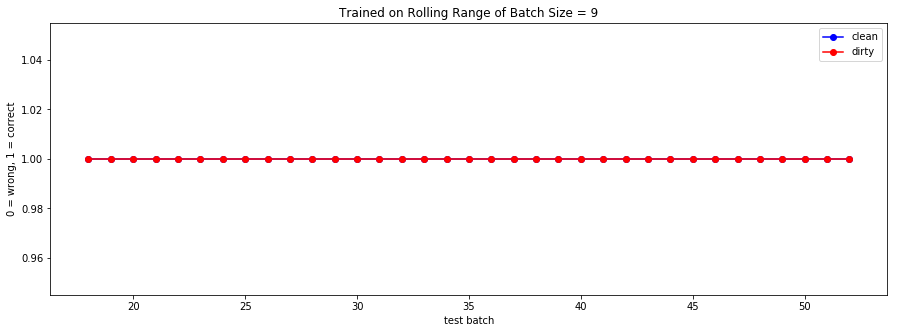

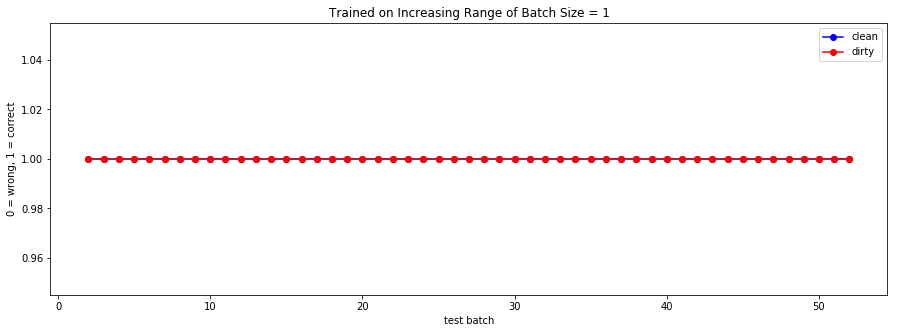

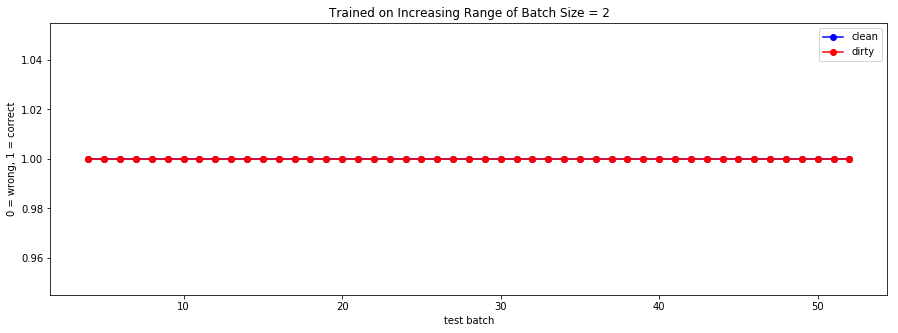

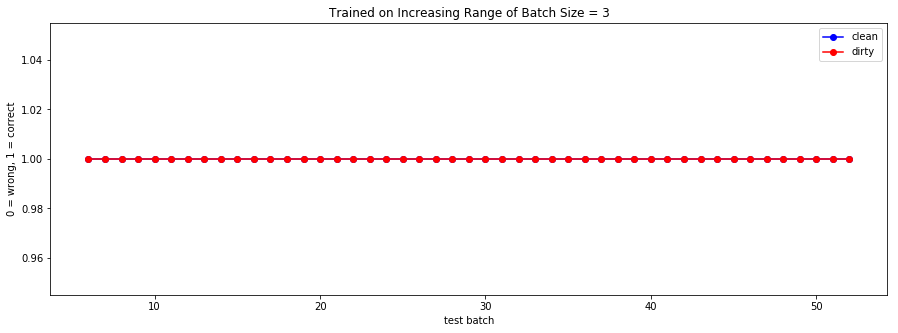

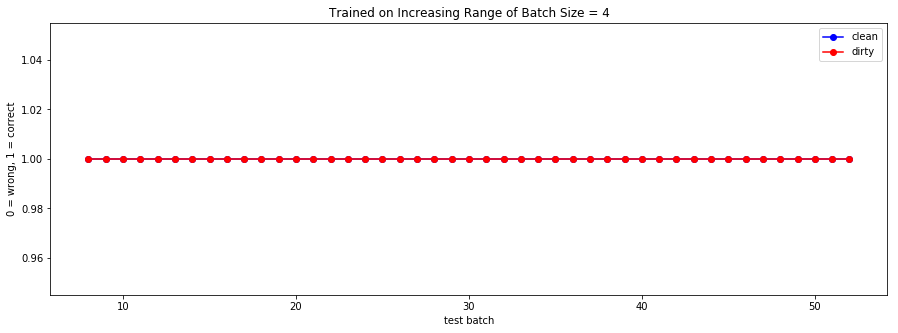

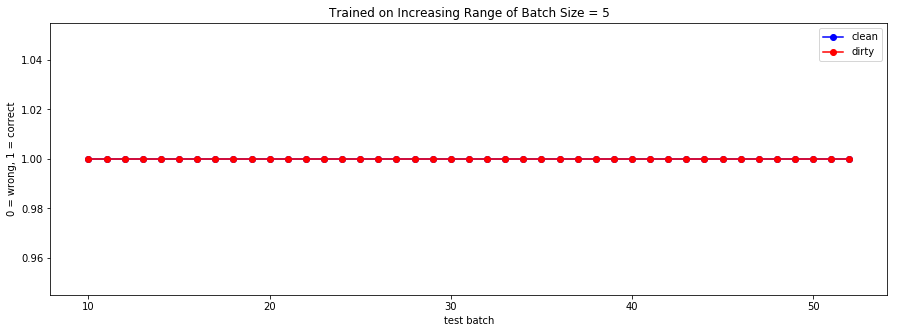

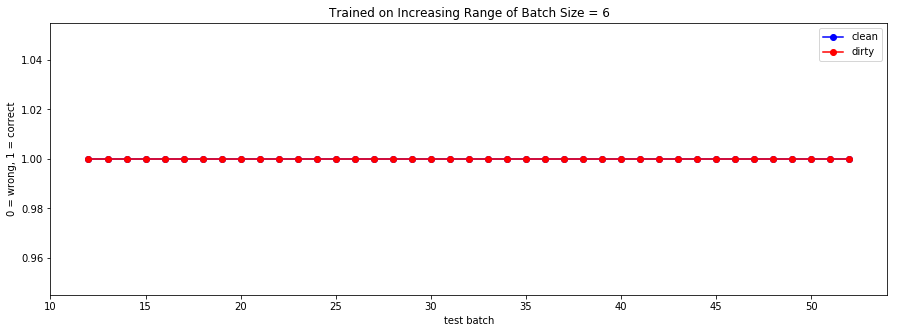

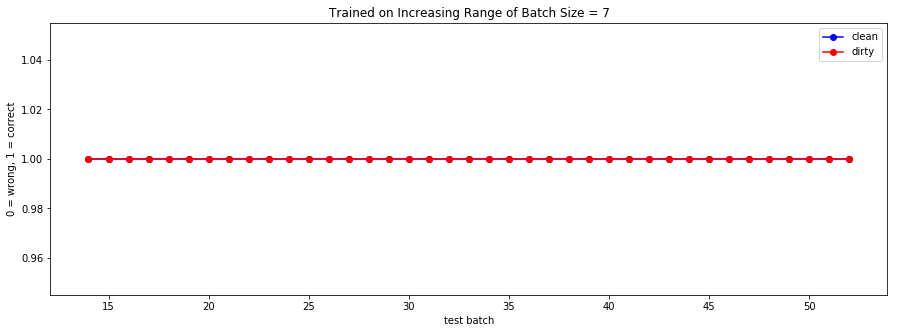

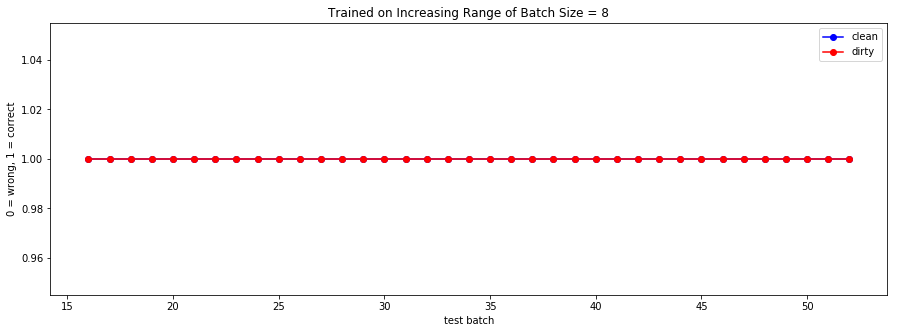

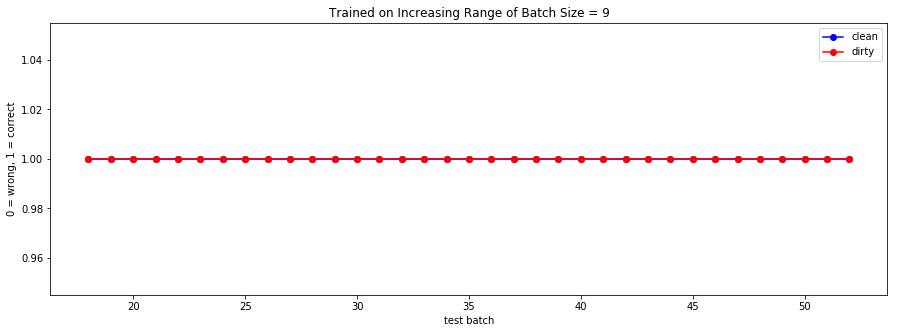

In [65]:
plot_batch(fb_analysis, range(1, 10))

In [56]:
flights_analysis = pd.DataFrame(columns=['train_type', 'batch_size', 'test_batch', 'clean_correct', 'dirty_correct'])
counter = 0

In [57]:
for train_type in ['rolling', 'increasing']:
    for batch_size in range(1, 10):
        for i in range(len(clean_flights)-batch_size):
            row = analysis(i, train_type, clean_flights, dirty_flights, batch_size)
            flights_analysis.loc[counter] = row
            counter = counter + 1

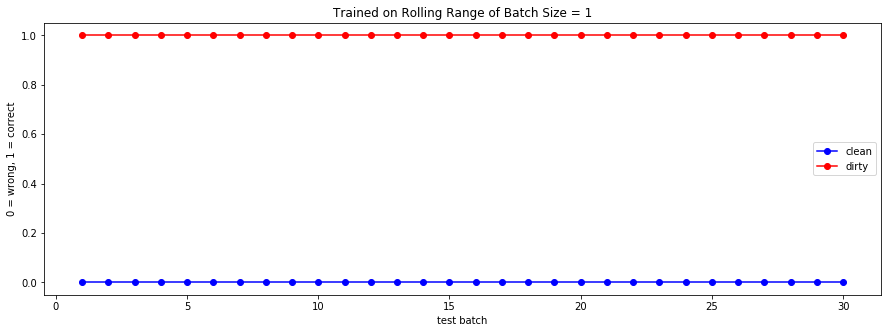

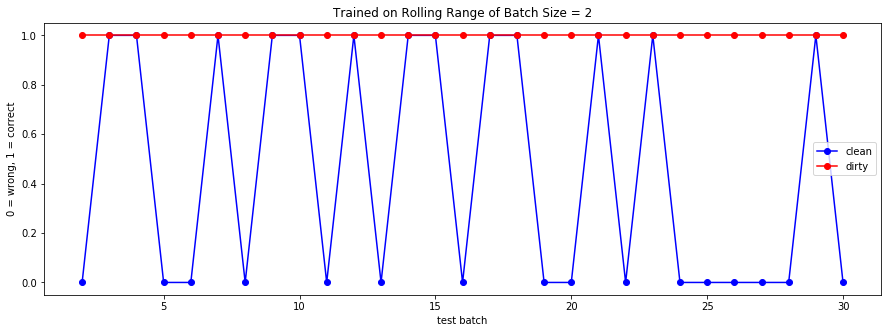

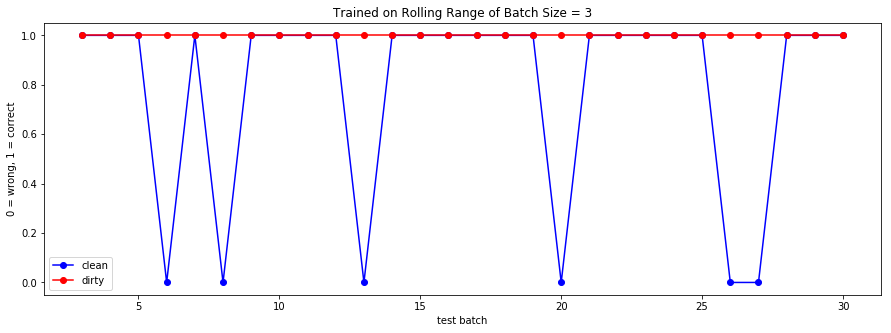

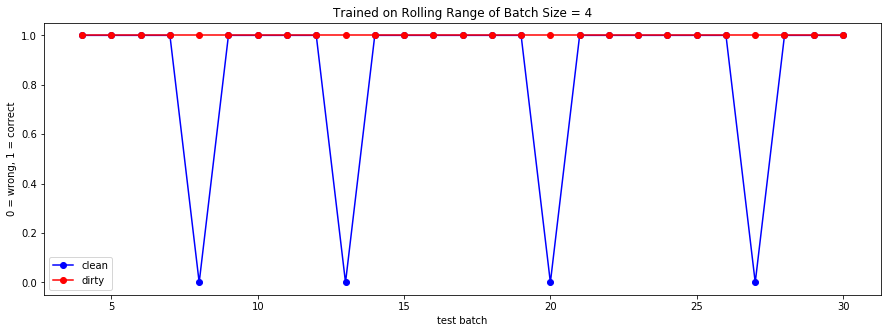

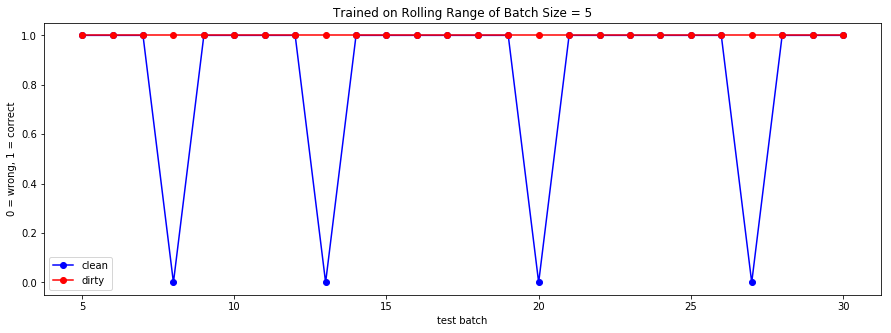

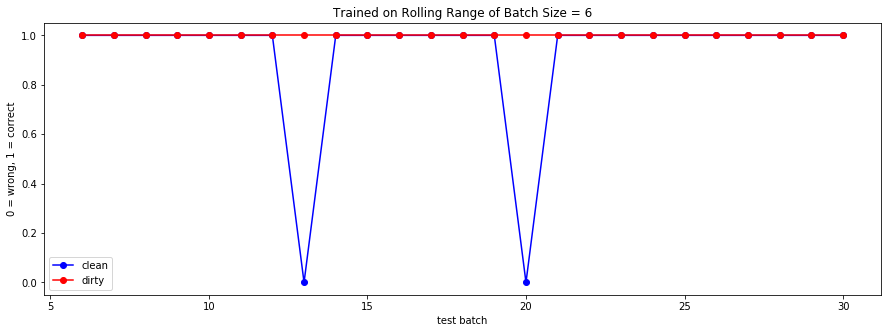

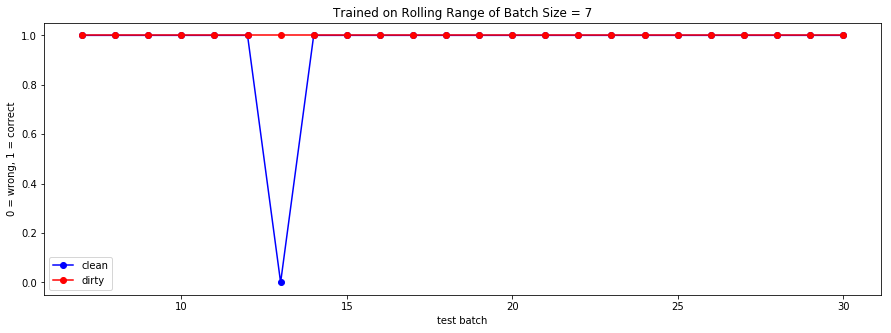

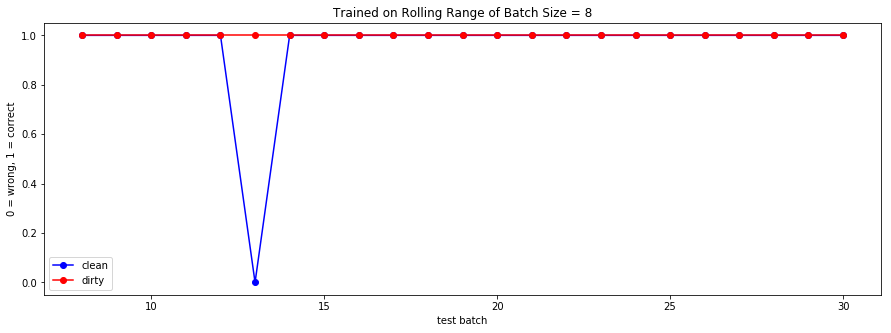

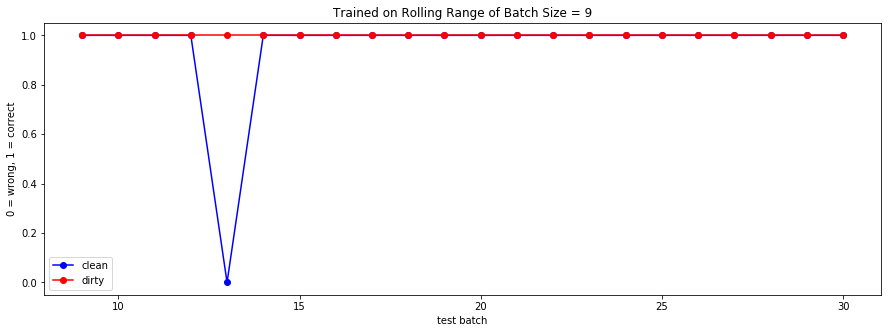

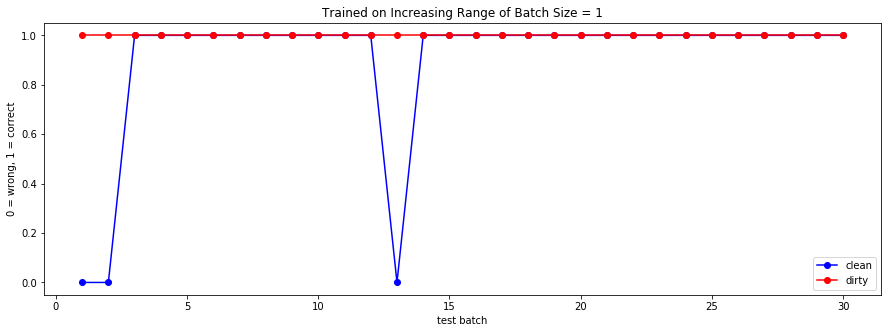

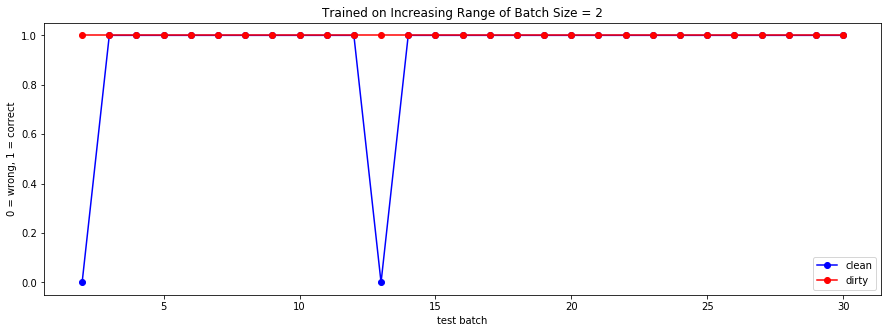

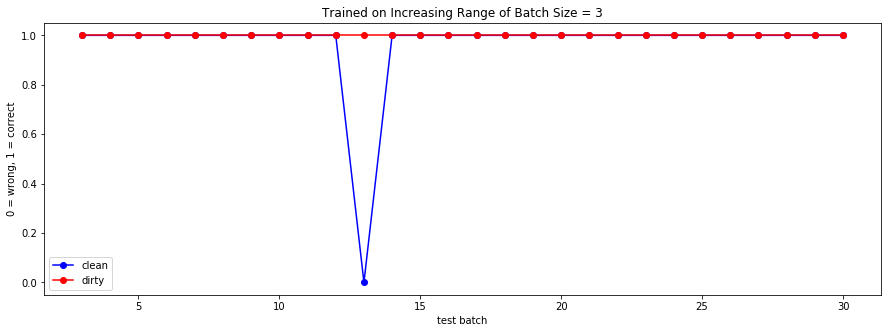

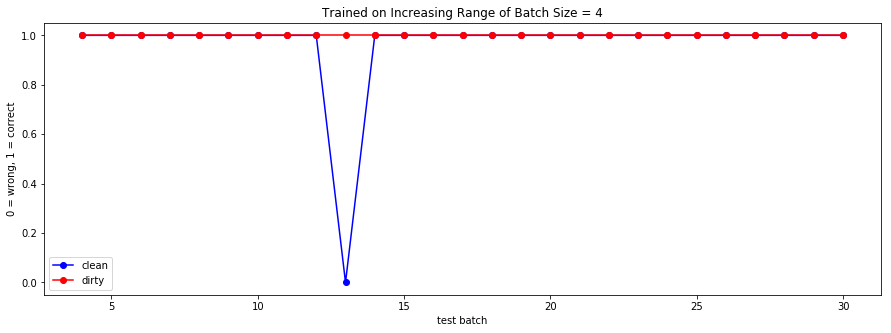

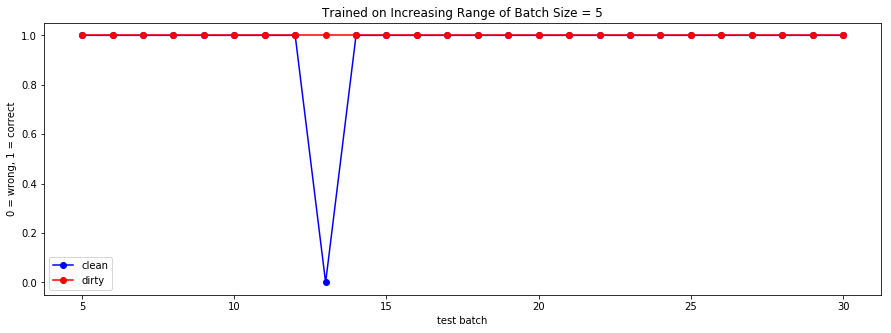

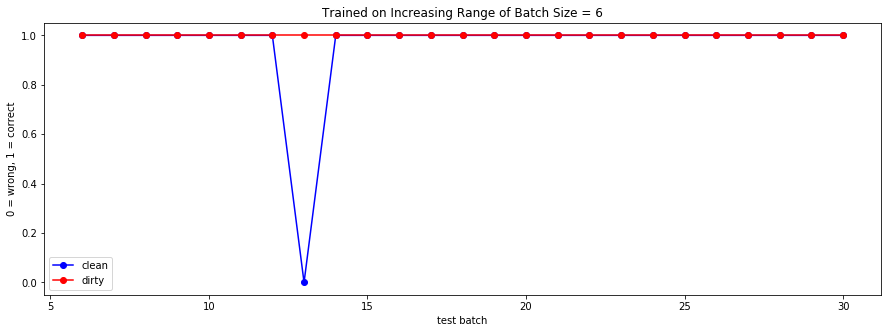

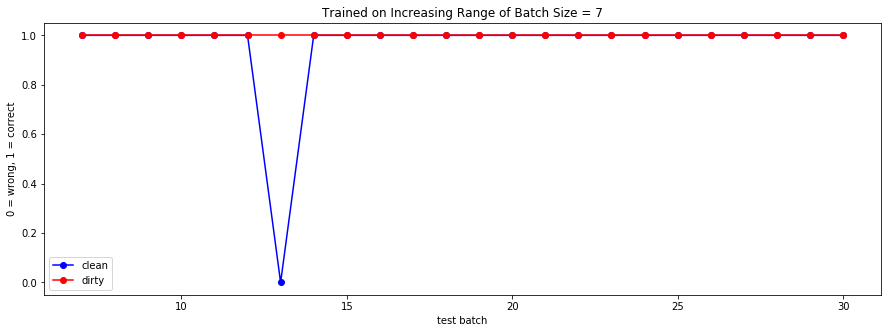

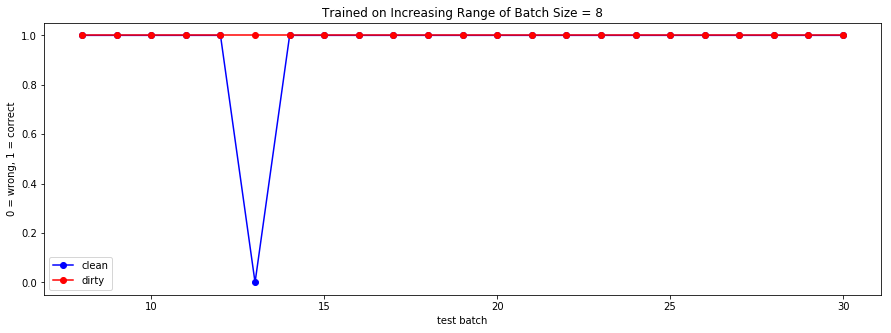

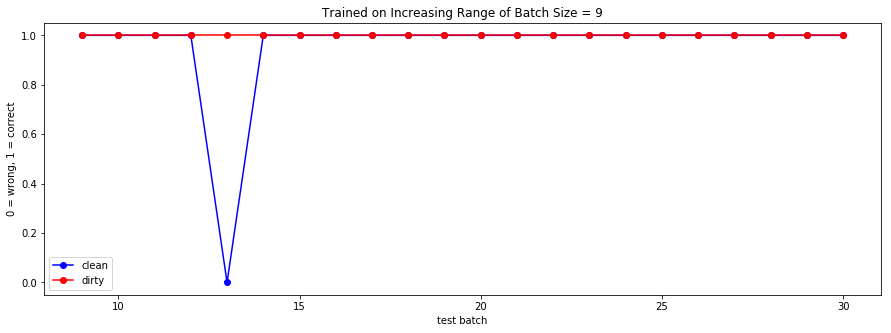

In [58]:
plot_batch(flights_analysis, range(1, 10))

In [68]:
flights_analysis = pd.DataFrame(columns=['batch_size', 'test_batch', 'clean_correct', 'dirty_correct'])
counter = 0

In [ ]:
fb_analysis.to_csv('fb_batch_analysis.csv')
flights_analysis.to_csv('flights_batch_analysis.csv')

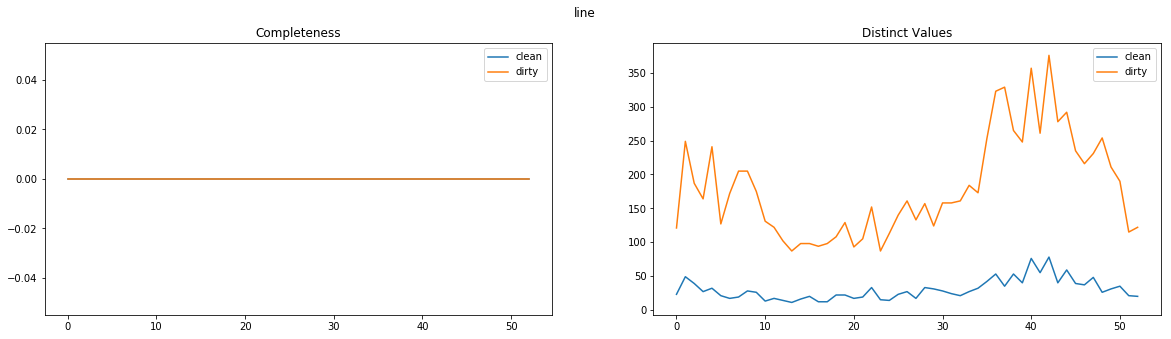

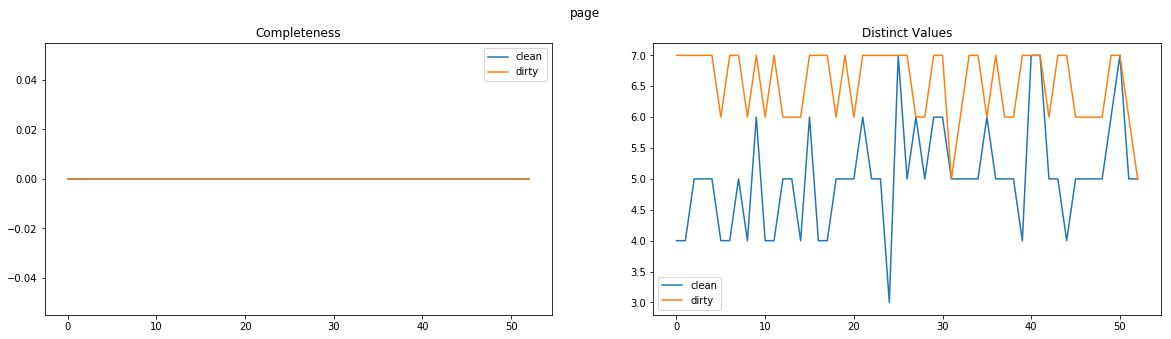

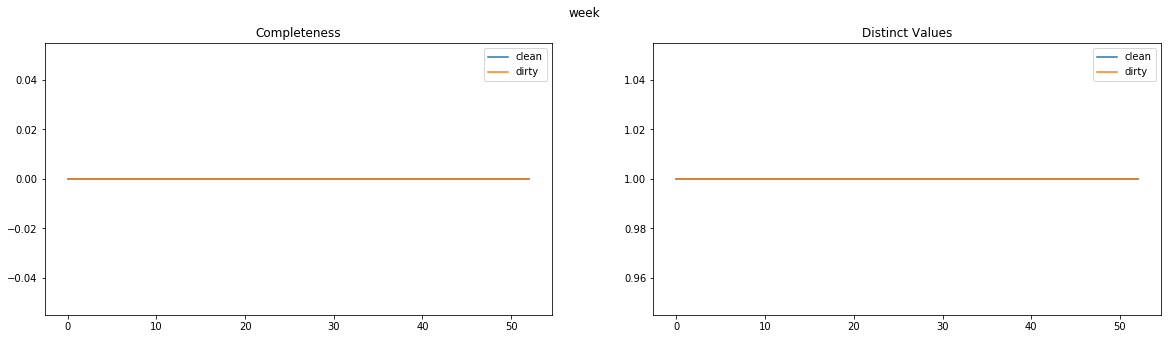

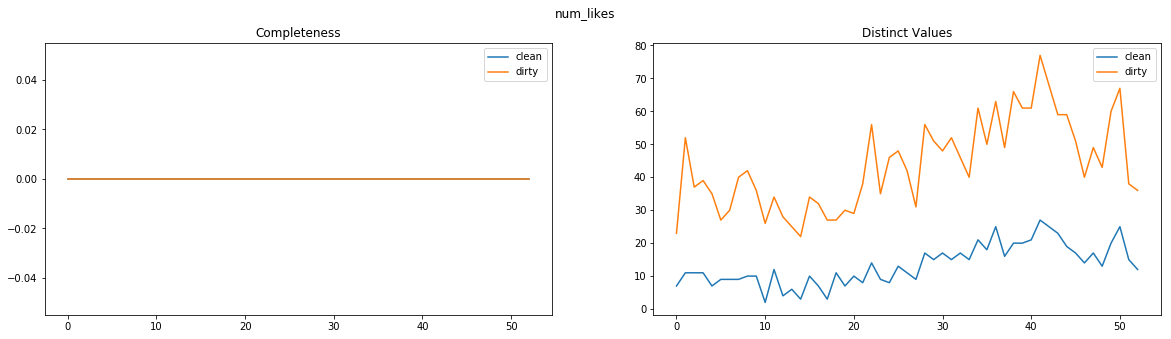

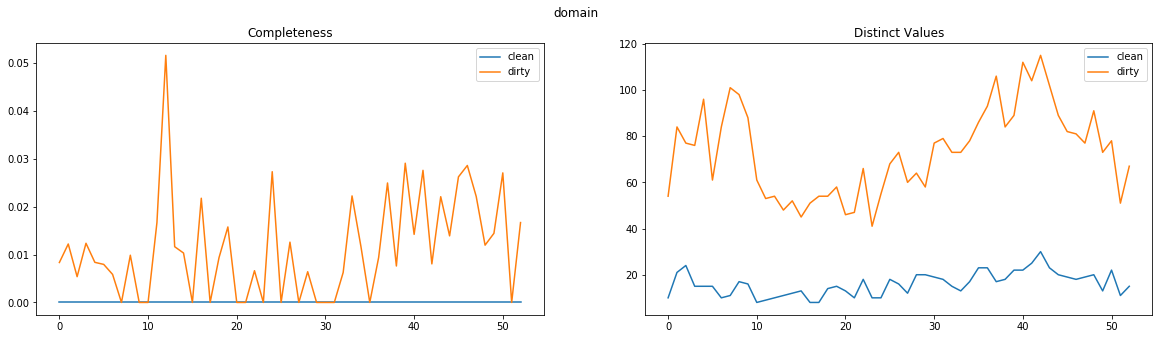

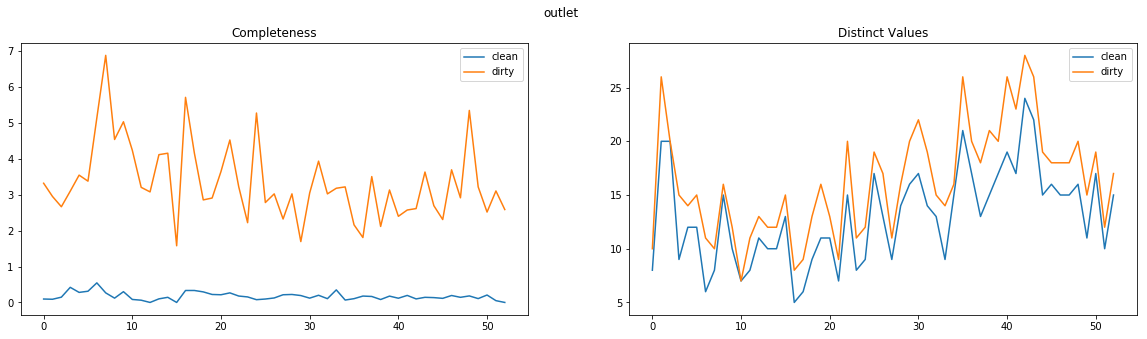

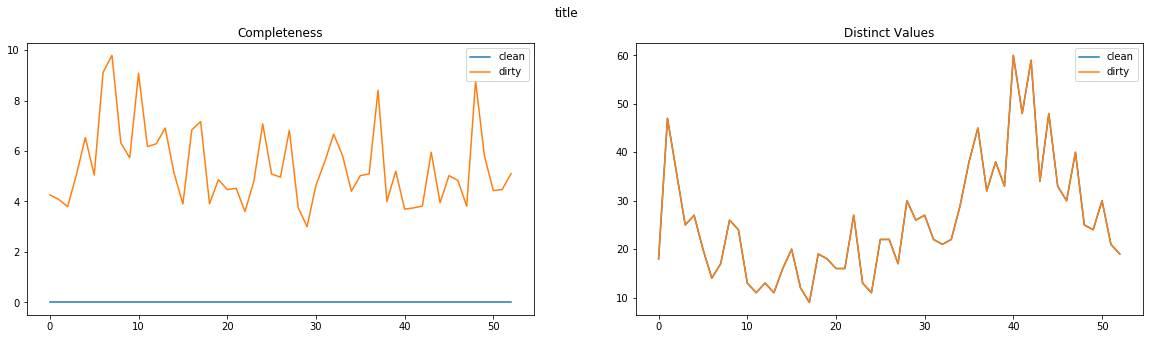

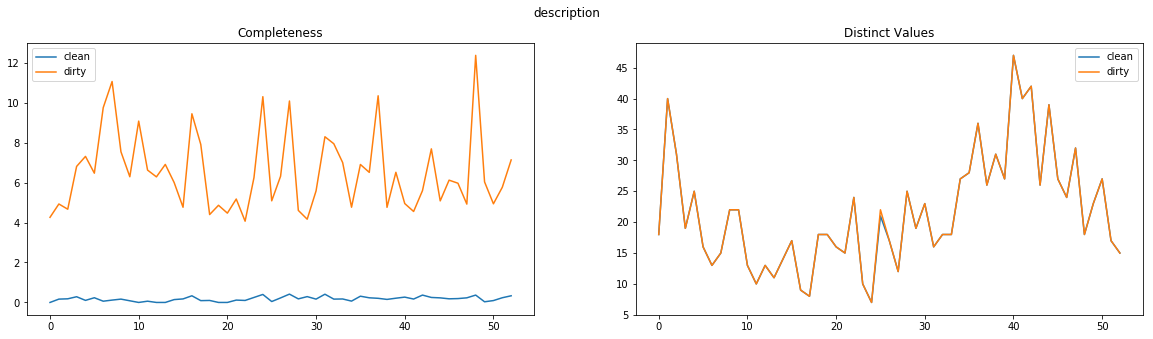

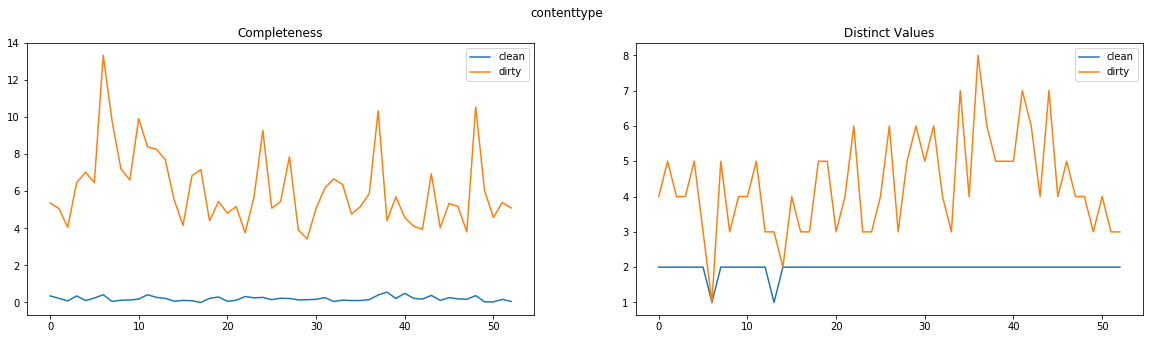

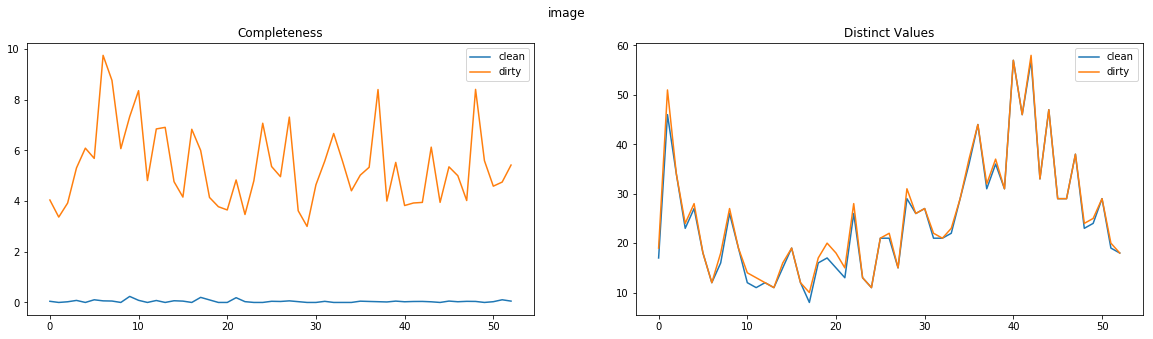

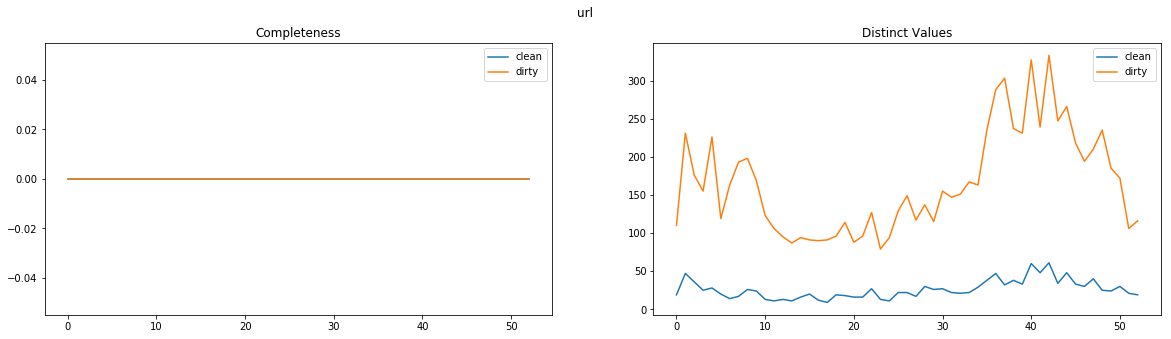

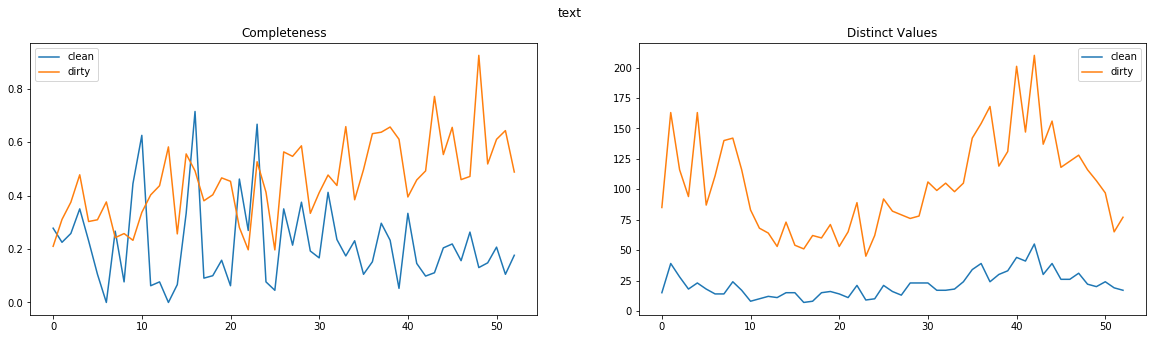

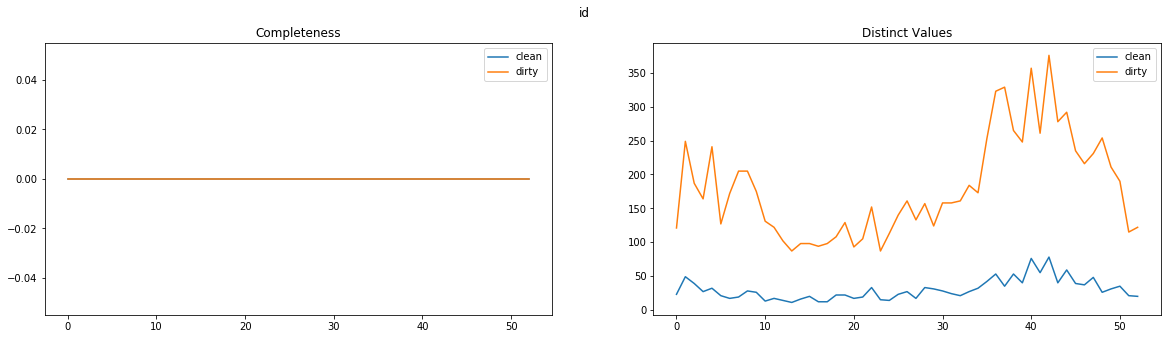

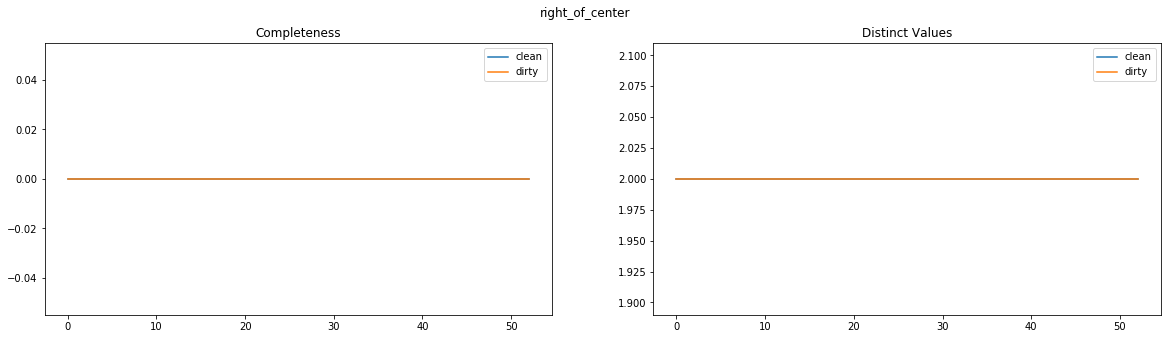

In [8]:
for column in fb_dirty_completeness_ratio_df.index.tolist():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle(column)
    ax1.title.set_text('Completeness')
    ax2.title.set_text('Distinct Values')
    ax1.plot(np.arange(fb_clean_completeness_ratio_df.shape[1]), fb_clean_completeness_ratio_df.loc[column].values, label = 'clean')
    ax1.plot(np.arange(fb_dirty_completeness_ratio_df.shape[1]), fb_dirty_completeness_ratio_df.loc[column].values, label = 'dirty')
    ax2.plot(np.arange(fb_clean_distinct_counts_df.shape[1]), fb_clean_distinct_counts_df.loc[column].values, label = 'clean')
    ax2.plot(np.arange(fb_dirty_distinct_counts_df.shape[1]), fb_dirty_distinct_counts_df.loc[column].values, label = 'dirty')
    ax1.legend()
    ax2.legend()
    plt.show()

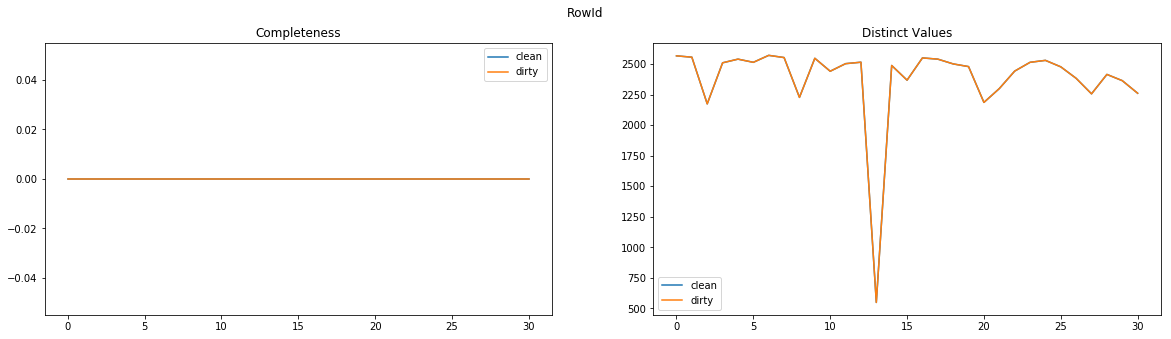

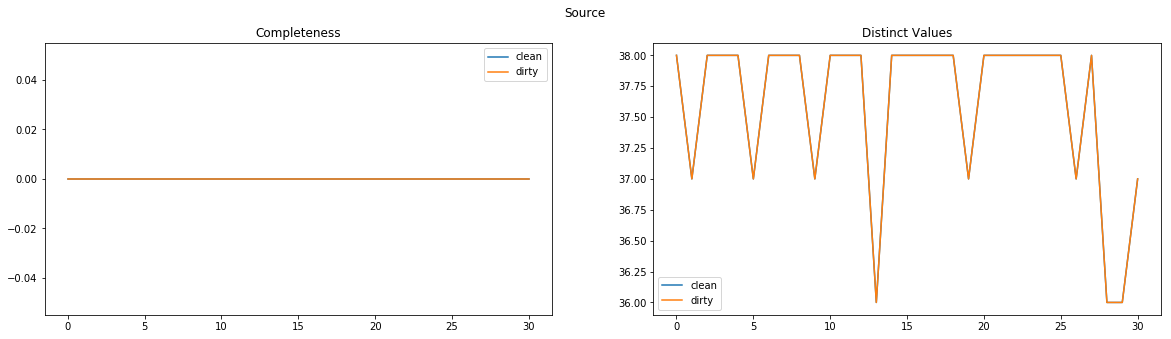

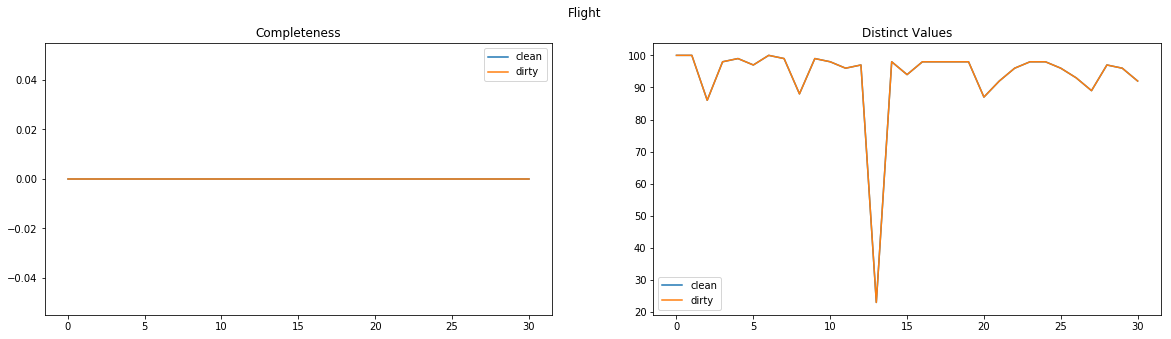

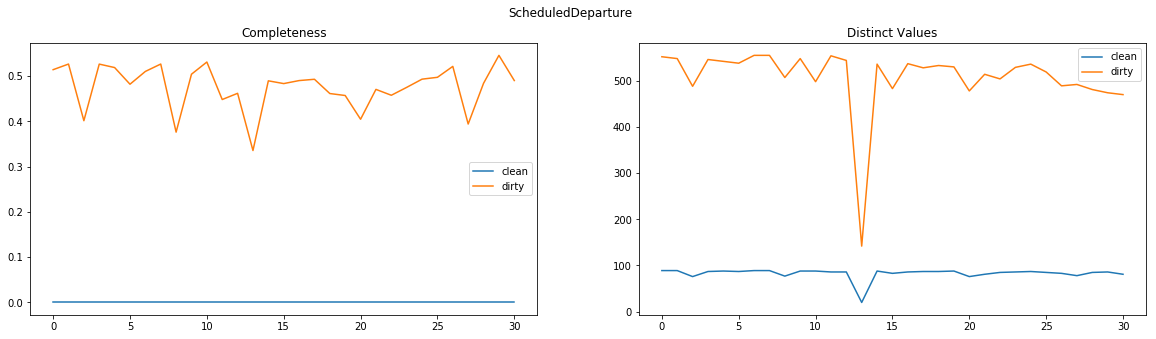

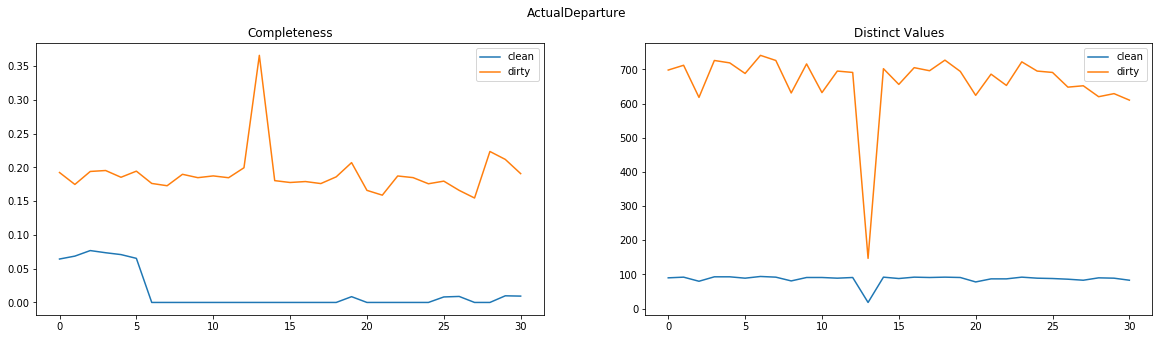

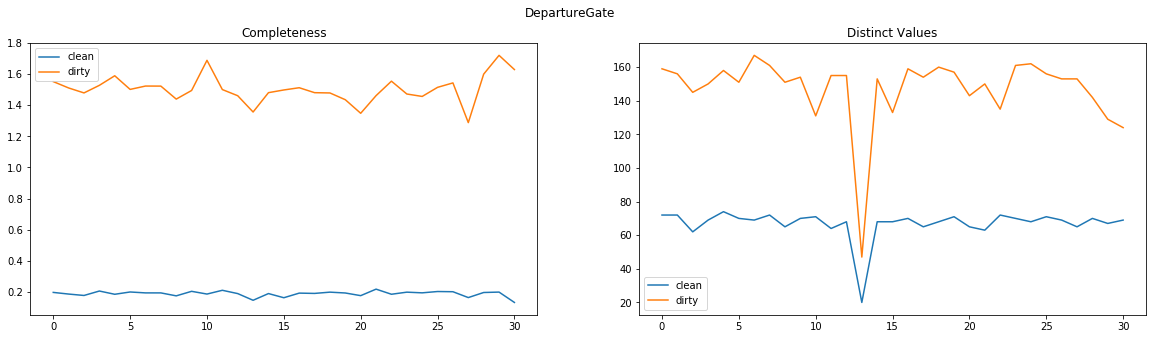

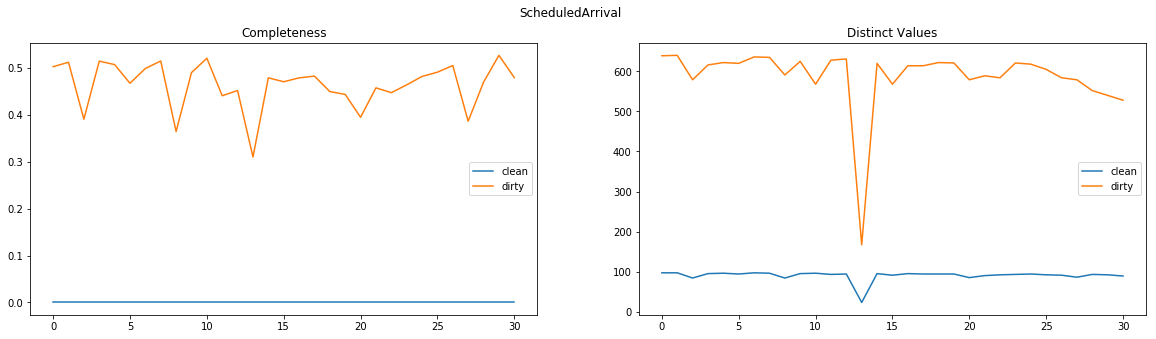

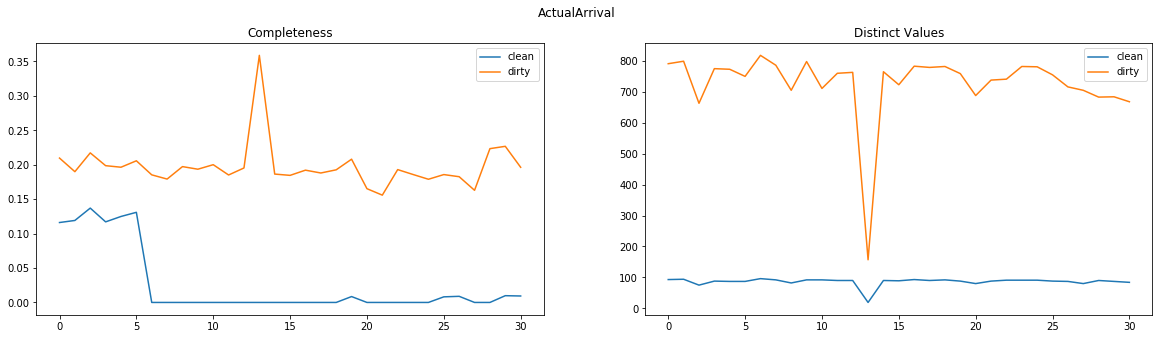

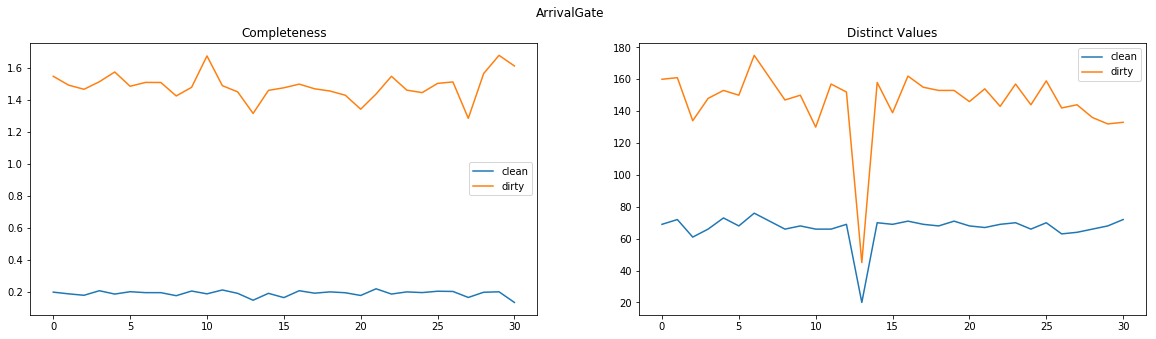

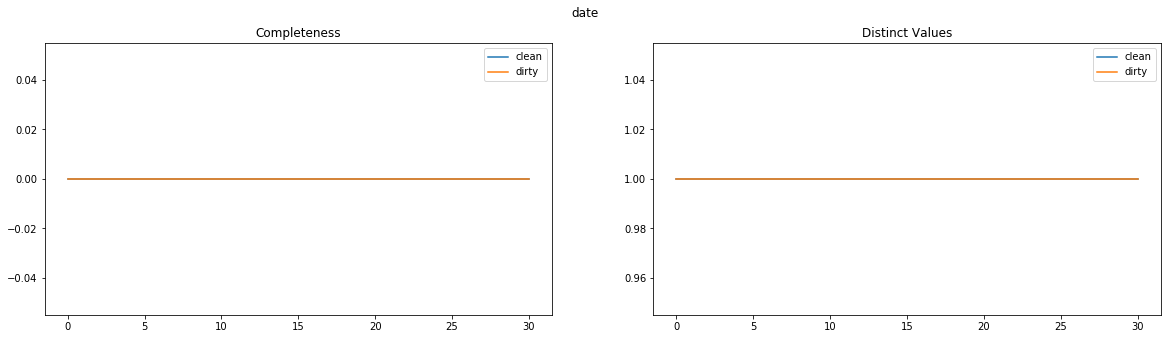

In [12]:
for column in flights_dirty_completeness_ratio_df.index.tolist():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle(column)
    ax1.title.set_text('Completeness')
    ax2.title.set_text('Distinct Values')
    ax1.plot(np.arange(flights_clean_completeness_ratio_df.shape[1]), flights_clean_completeness_ratio_df.loc[column].values, label = 'clean')
    ax1.plot(np.arange(flights_dirty_completeness_ratio_df.shape[1]), flights_dirty_completeness_ratio_df.loc[column].values, label = 'dirty')
    ax2.plot(np.arange(flights_clean_distinct_counts_df.shape[1]), flights_clean_distinct_counts_df.loc[column].values, label = 'clean')
    ax2.plot(np.arange(flights_dirty_distinct_counts_df.shape[1]), flights_dirty_distinct_counts_df.loc[column].values, label = 'dirty')
    ax1.legend()
    ax2.legend()
    plt.show()